<a href="https://colab.research.google.com/github/smkmohsin/NETFLIX-MOVIES-AND-TV-SHOWS-CLUSTERING/blob/main/NETFLIX_MOVIES_AND_TV_SHOWS_CLUSTERING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.

In 2018, they released an interesting report which shows that the number of TV shows on Netflix has nearly tripled since 2010. The streaming service’s number of movies has decreased by more than 2,000 titles since 2010, while its number of TV shows has nearly tripled. It will be interesting to explore what all other insights can be obtained from the same dataset.

Integrating this dataset with other external datasets such as IMDB ratings, rotten tomatoes can also provide many interesting findings.

## <b>In this  project, you are required to do </b>
1. Exploratory Data Analysis 

2. Understanding what type content is available in different countries

3. Is Netflix has increasingly focusing on TV rather than movies in recent years.
4. Clustering similar content by matching text-based features



# **Attribute Information**

1. show_id : Unique ID for every Movie / Tv Show

2. type : Identifier - A Movie or TV Show

3. title : Title of the Movie / Tv Show

4. director : Director of the Movie

5. cast : Actors involved in the movie / show

6. country : Country where the movie / show was produced

7. date_added : Date it was added on Netflix

8. release_year : Actual Releaseyear of the movie / show

9. rating : TV Rating of the movie / show

10. duration : Total Duration - in minutes or number of seasons

11. listed_in : Genere

12. description: The Summary description

In [59]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from matplotlib import rcParams

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE


%matplotlib inline

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# Importing the dataset
dataset = pd.read_csv('/content/drive/MyDrive/Almabetter/Module 4/Capstone Project 3/NETFLIX_MOVIES_AND_TV_SHOWS_CLUSTERING.csv')

# <b> Exploratory Data Analysis

In [62]:
dataset.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [63]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [64]:
dataset.describe()

,release_year
count,7787.000000
mean,2013.932580
std,8.757395
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2018.000000
max,2021.000000


In [65]:
dataset.shape

(7787, 12)

## Data Cleaning

In [66]:
# Missing Value Count Function
def show_missing():
    missing = dataset.columns[dataset.isnull().any()].tolist()
    return missing

# Missing data counts and percentage
print('Missing Data Count')
print(dataset[show_missing()].isnull().sum().sort_values(ascending = False))
print('--'*50)
print('Missing Data Percentage')
print(round(dataset[show_missing()].isnull().sum().sort_values(ascending = False)/len(dataset)*100,2))

Missing Data Count
director      2389
cast           718
country        507
date_added      10
rating           7
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
director      30.68
cast           9.22
country        6.51
date_added     0.13
rating         0.09
dtype: float64


In [67]:
dataset['show_id'].unique()

array(['s1', 's2', 's3', ..., 's7785', 's7786', 's7787'], dtype=object)

In [68]:
dataset['title'].unique()

array(['3%', '7:19', '23:59', ..., 'Zulu Man in Japan',
       "Zumbo's Just Desserts", "ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS"],
      dtype=object)

In [69]:
# Drop unnecessary features
dataset.drop(['director','cast','show_id'], axis=1, inplace=True)

# Drop rows with null value
dataset.dropna(inplace=True)

In [70]:
# After dropping some features and null values
dataset.shape

(7265, 9)

In [71]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7265 entries, 0 to 7786
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   type          7265 non-null   object
 1   title         7265 non-null   object
 2   country       7265 non-null   object
 3   date_added    7265 non-null   object
 4   release_year  7265 non-null   int64 
 5   rating        7265 non-null   object
 6   duration      7265 non-null   object
 7   listed_in     7265 non-null   object
 8   description   7265 non-null   object
dtypes: int64(1), object(8)
memory usage: 567.6+ KB


In [72]:
dataset.head()

,type,title,country,date_added,release_year,rating,duration,listed_in,description
0,TV Show,3%,Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,Movie,7:19,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,Movie,23:59,Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,Movie,9,United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,Movie,21,United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


## Top 10 countries producing contents on Netflix

In [73]:
# Top 10 countries producing contents in netflix
top_10_country = dataset['country'].value_counts()[:10].reset_index().rename(columns={'index':'country', 'country': 'count'})
top_10_country

,country,count
0,United States,2546
1,India,923
2,United Kingdom,396
3,Japan,224
4,South Korea,183
5,Canada,177
6,Spain,134
7,France,115
8,Egypt,101
9,Mexico,100


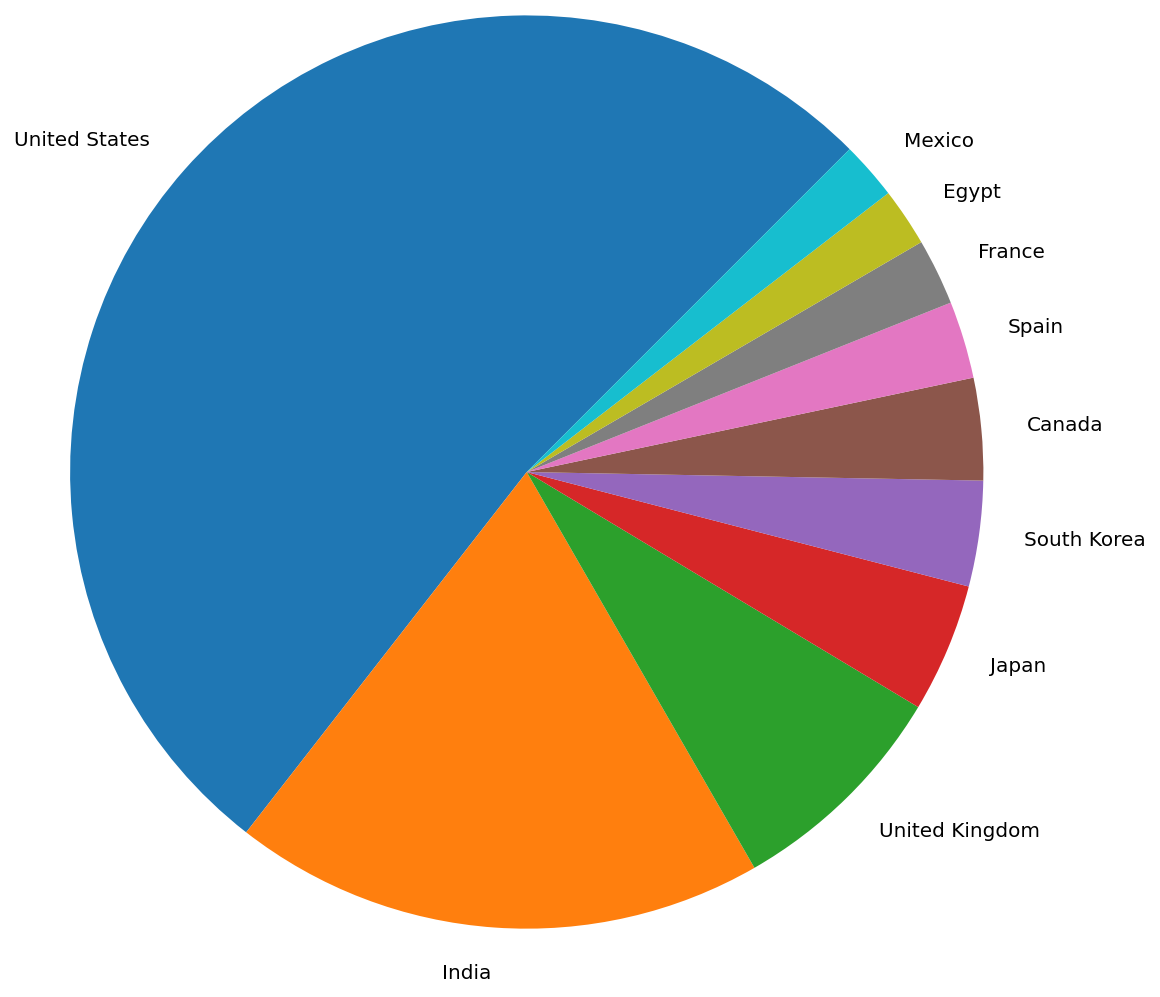

In [105]:
plt.pie(top_10_country['count'].values, labels=top_10_country['country'], radius=1.5, startangle=45)
plt.show()

In [75]:
ratings_count = dataset[['rating','type']].value_counts().reset_index().rename(columns={0: 'count'})
ratings_count

,rating,type,count
0,TV-MA,Movie,1767
1,TV-14,Movie,1216
2,TV-MA,TV Show,935
3,R,Movie,662
4,TV-14,TV Show,576
5,TV-PG,Movie,483
6,PG-13,Movie,383
7,TV-PG,TV Show,256
8,PG,Movie,244
9,TV-Y7,TV Show,144


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


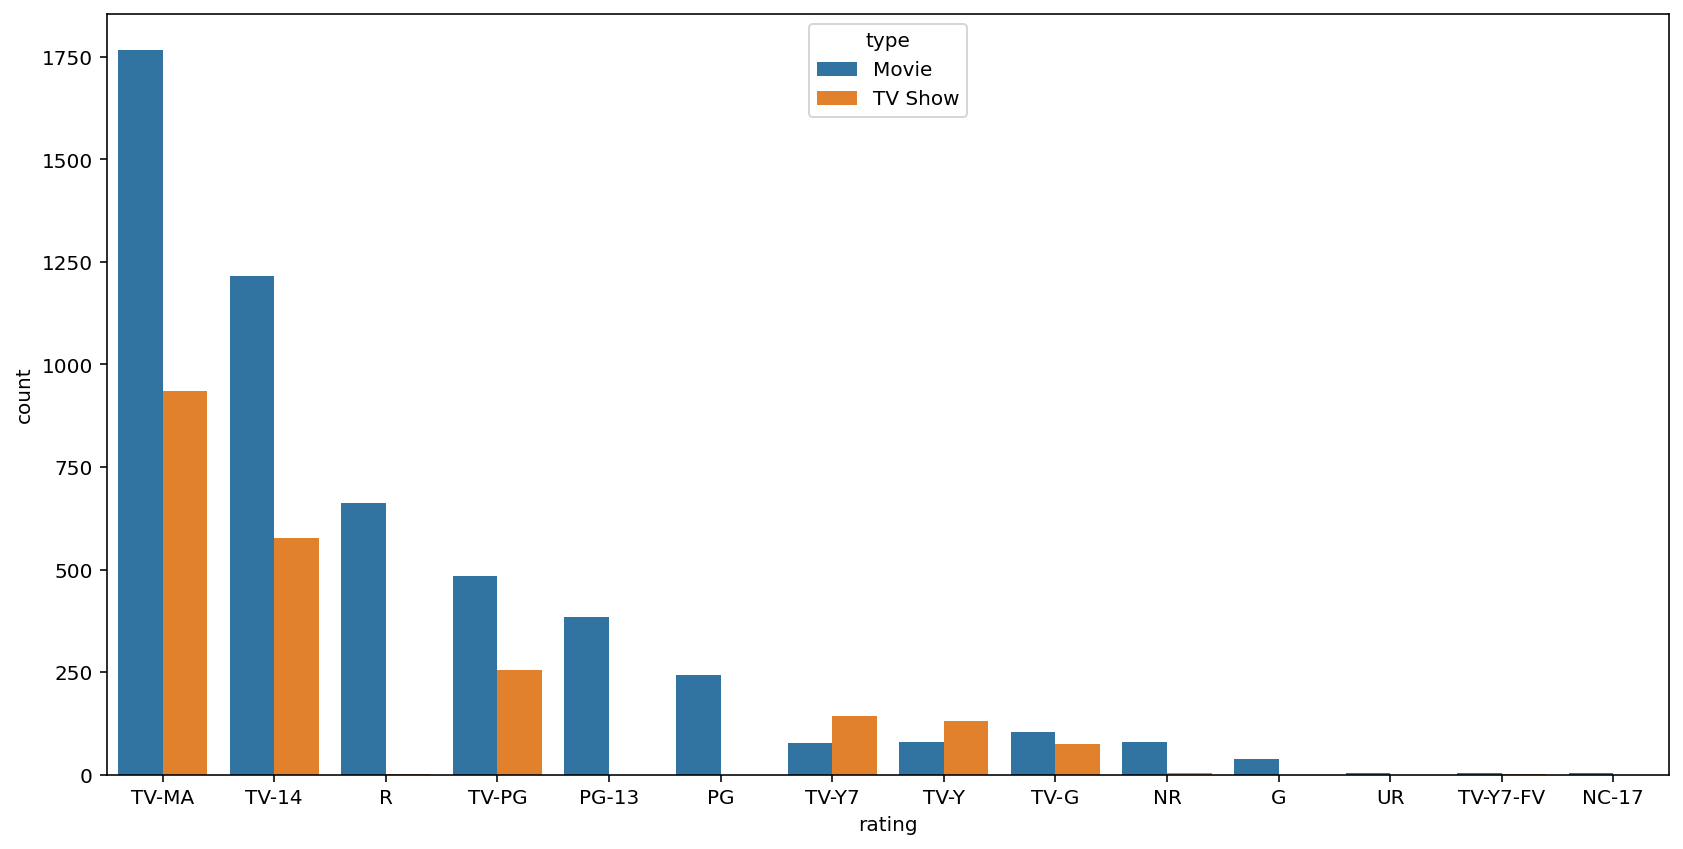

In [106]:
# Visualize contents based on ratings
sns.barplot('rating', 'count',hue='type',data=ratings_count)
rcParams['figure.figsize'] = 14,7

<b><u>Detail about Ratings:</u></b>

**TV-Y:** All Children
Intended for children ages 2 to 6 and is not designed or expected to frighten.

**TV-Y7:** Directed to Older Children
Intended for children ages 7 and older. Best suited for children who know the difference between real life and make-believe. Contains mild fantasy or comedic violence. Some content could frighten younger children (under age 7).

**TV-Y7 FV:** Directed to Older Children - Fantasy Violence
Intended for older children. Contains fantasy violence more combative than TVY7 programs.

**TV-G:** General Audience
Intended for all ages. Contains little or no violence, no strong language and little or no sexual dialogue or situations.

**TV-PG:** Parental Guidance Suggested
Intended for younger children in the company of an adult. Possibly contains some suggestive dialogue, infrequent coarse language, some sexual situations or some moderate violence.

**TV-14:** Parents Strongly Cautioned
Intended for children ages 14 and older in the company of an adult. Possibly contains intensely suggestive dialogue, strong coarse language, intense sexual situations or intense violence.

**TV-MA:** Mature Audience Only
Intended for adults and may be unsuitable for children under 17. Possibly contains crude indecent language, explicit sexual activity or graphic violence.

**G:** General Audiences
This program is designed to be appropriate for all ages. This rating indicates a film contains nothing that would offend parents for viewing by children.

**PG:** Parental Guidance Suggested
Parents are urged to give parental guidance. This film may contain some material parents might not like for their young children.

**PG-13:** Parents Strongly Cautioned
Some material may not be suited for children under age 13. May contain violence, nudity, sensuality, language, adult activities or other elements beyond a PG rating, but doesn’t reach the restricted R category.

**R:** Restricted
This rating is for films specifically designed to be viewed by adults and therefore may be unsuitable for children under 17.

**NC-17:** Clearly Adult
This rating is applied to films the MPAA believes most parents will consider inappropriate for children 17 and under. It indicates only that adult content is more intense than in an R rated movie.

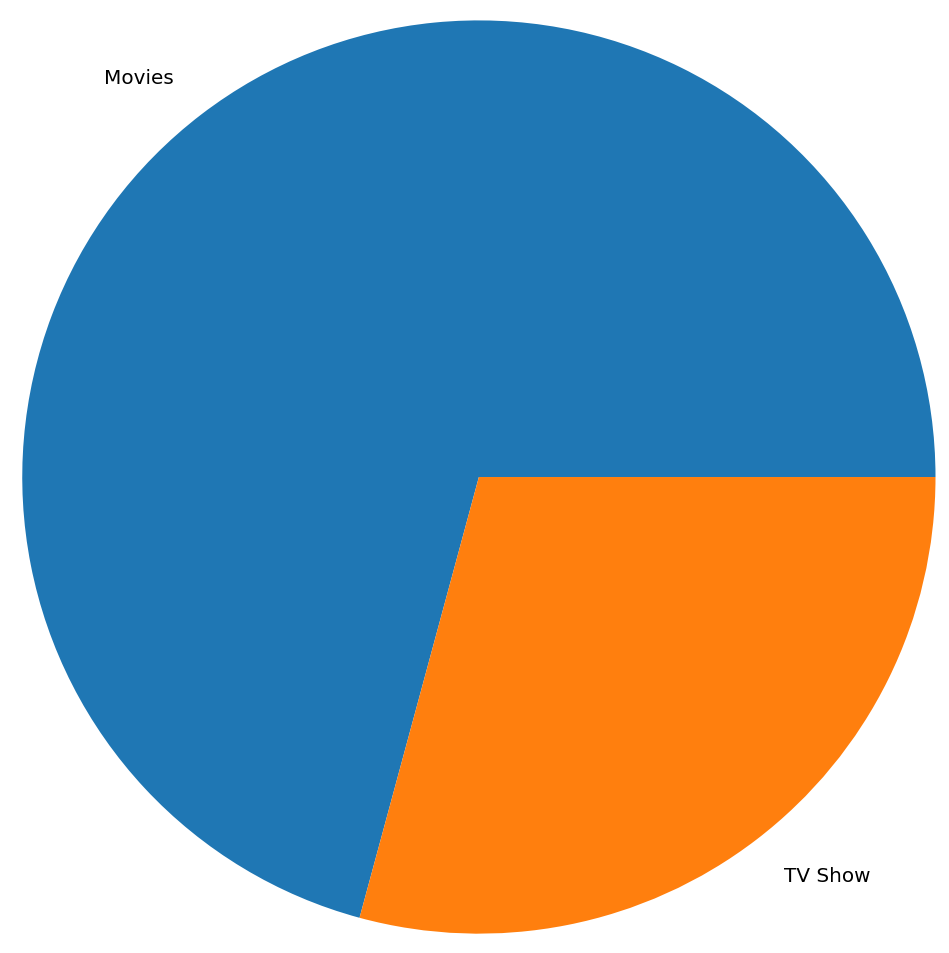

In [107]:
plt.pie(dataset['type'].value_counts(), labels=['Movies', 'TV Show'], radius=1.5)
plt.show()

In [109]:
def get_unique_list(col_name, dataset_name):

  # Extract unique names
  list_ = []

  for list_of_name in  dataset_name[col_name].unique():
    split_list_of_name = list_of_name.split(sep=', ')
    for name in split_list_of_name:
      list_.append(name)

  # Eliminate repeated names
  list_ = list(set(list_)) 
  return list_

In [110]:
list_of_genres = get_unique_list('listed_in', dataset)
list_of_genres

['TV Sci-Fi & Fantasy',
 'International Movies',
 'Romantic TV Shows',
 'Reality TV',
 'TV Dramas',
 'Teen TV Shows',
 'TV Thrillers',
 'Thrillers',
 'Spanish-Language TV Shows',
 'Dramas',
 'Romantic Movies',
 'Stand-Up Comedy',
 'British TV Shows',
 'Stand-Up Comedy & Talk Shows',
 'Anime Features',
 'Independent Movies',
 'Music & Musicals',
 'TV Horror',
 'Children & Family Movies',
 'Crime TV Shows',
 'Horror Movies',
 'Cult Movies',
 'TV Mysteries',
 'Documentaries',
 'LGBTQ Movies',
 'Classic Movies',
 'TV Comedies',
 'TV Action & Adventure',
 'TV Shows',
 'Korean TV Shows',
 'Sports Movies',
 'Classic & Cult TV',
 'Anime Series',
 'Comedies',
 "Kids' TV",
 'International TV Shows',
 'Action & Adventure',
 'Docuseries',
 'Faith & Spirituality',
 'Movies',
 'Sci-Fi & Fantasy',
 'Science & Nature TV']

In [114]:
len(list_of_genres)

42

In [146]:
def get_genres_count(country):
  genres_count = dataset[dataset['country'] == country]['listed_in'].value_counts().reset_index().rename(columns={'index': 'listed_in', 'listed_in': 'count'})
  return genres_count

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

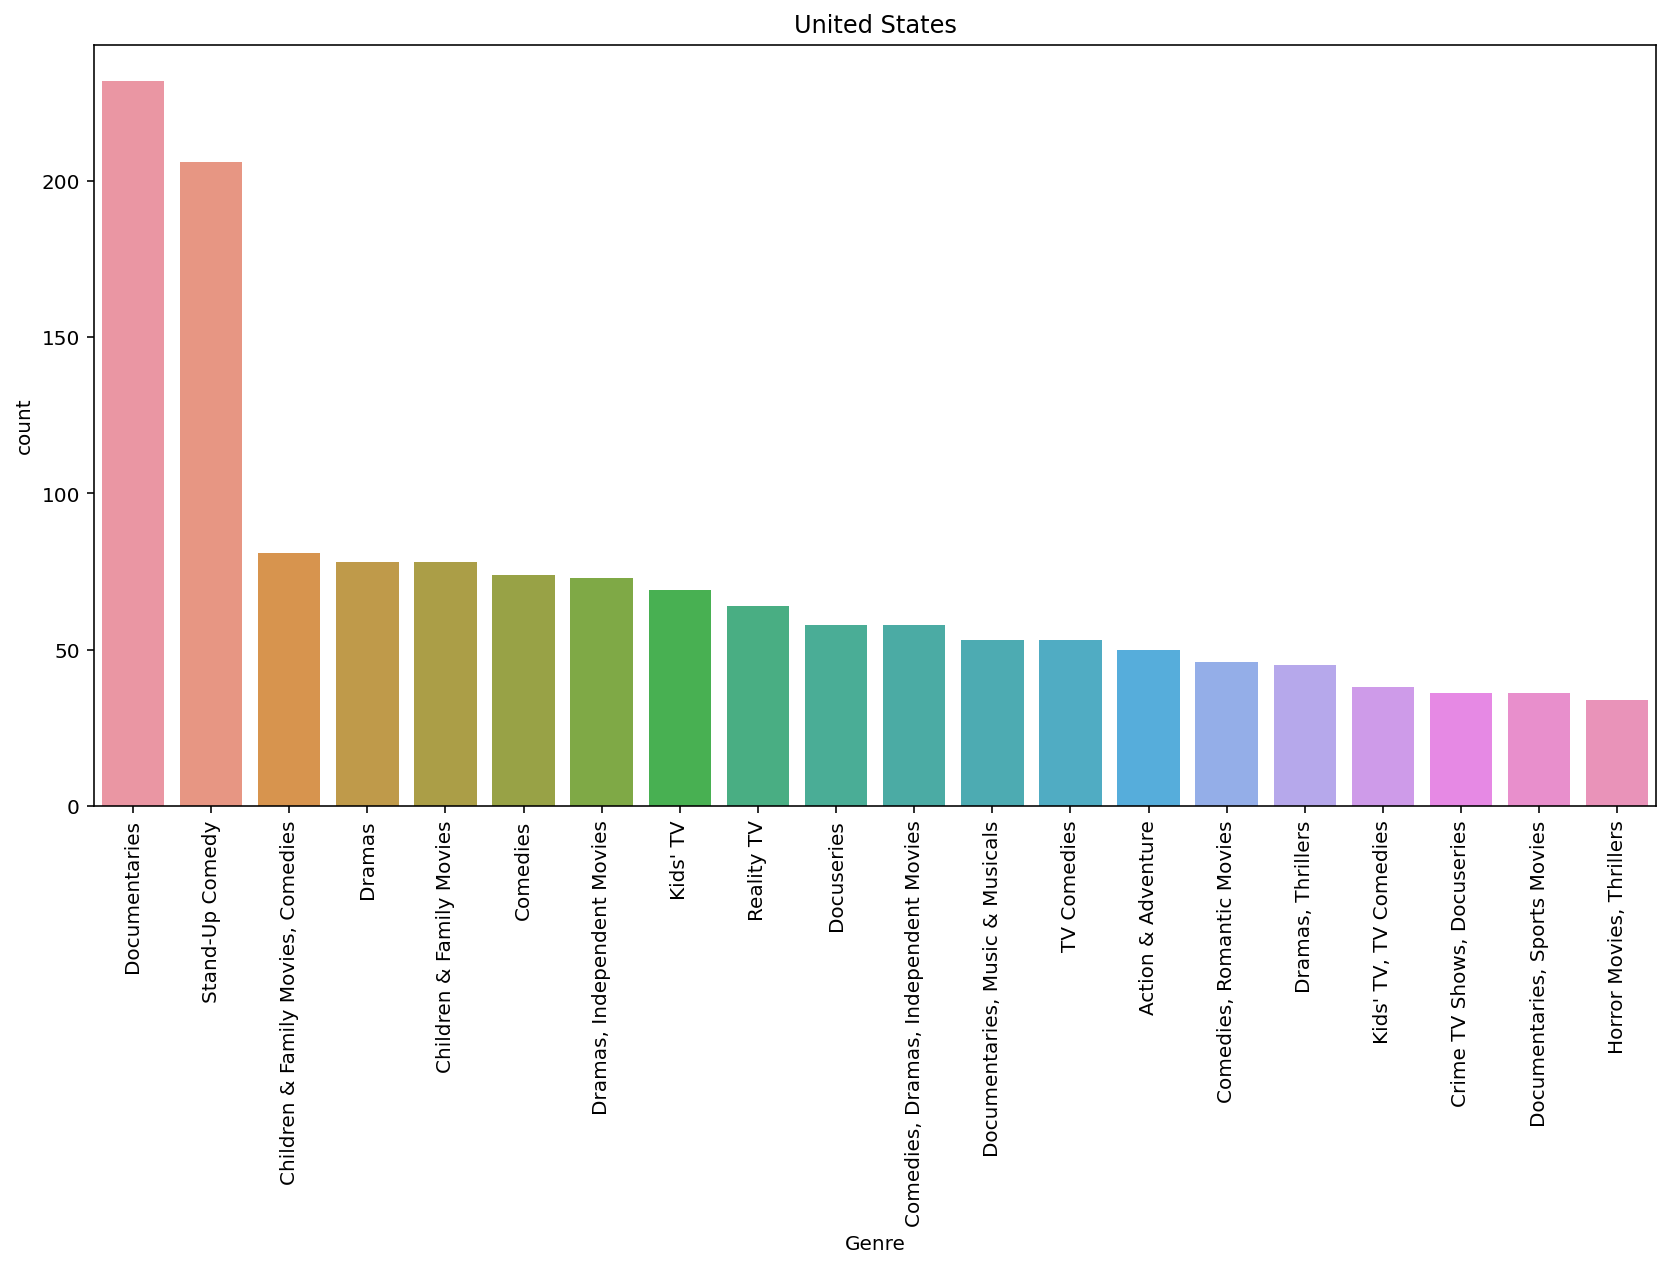

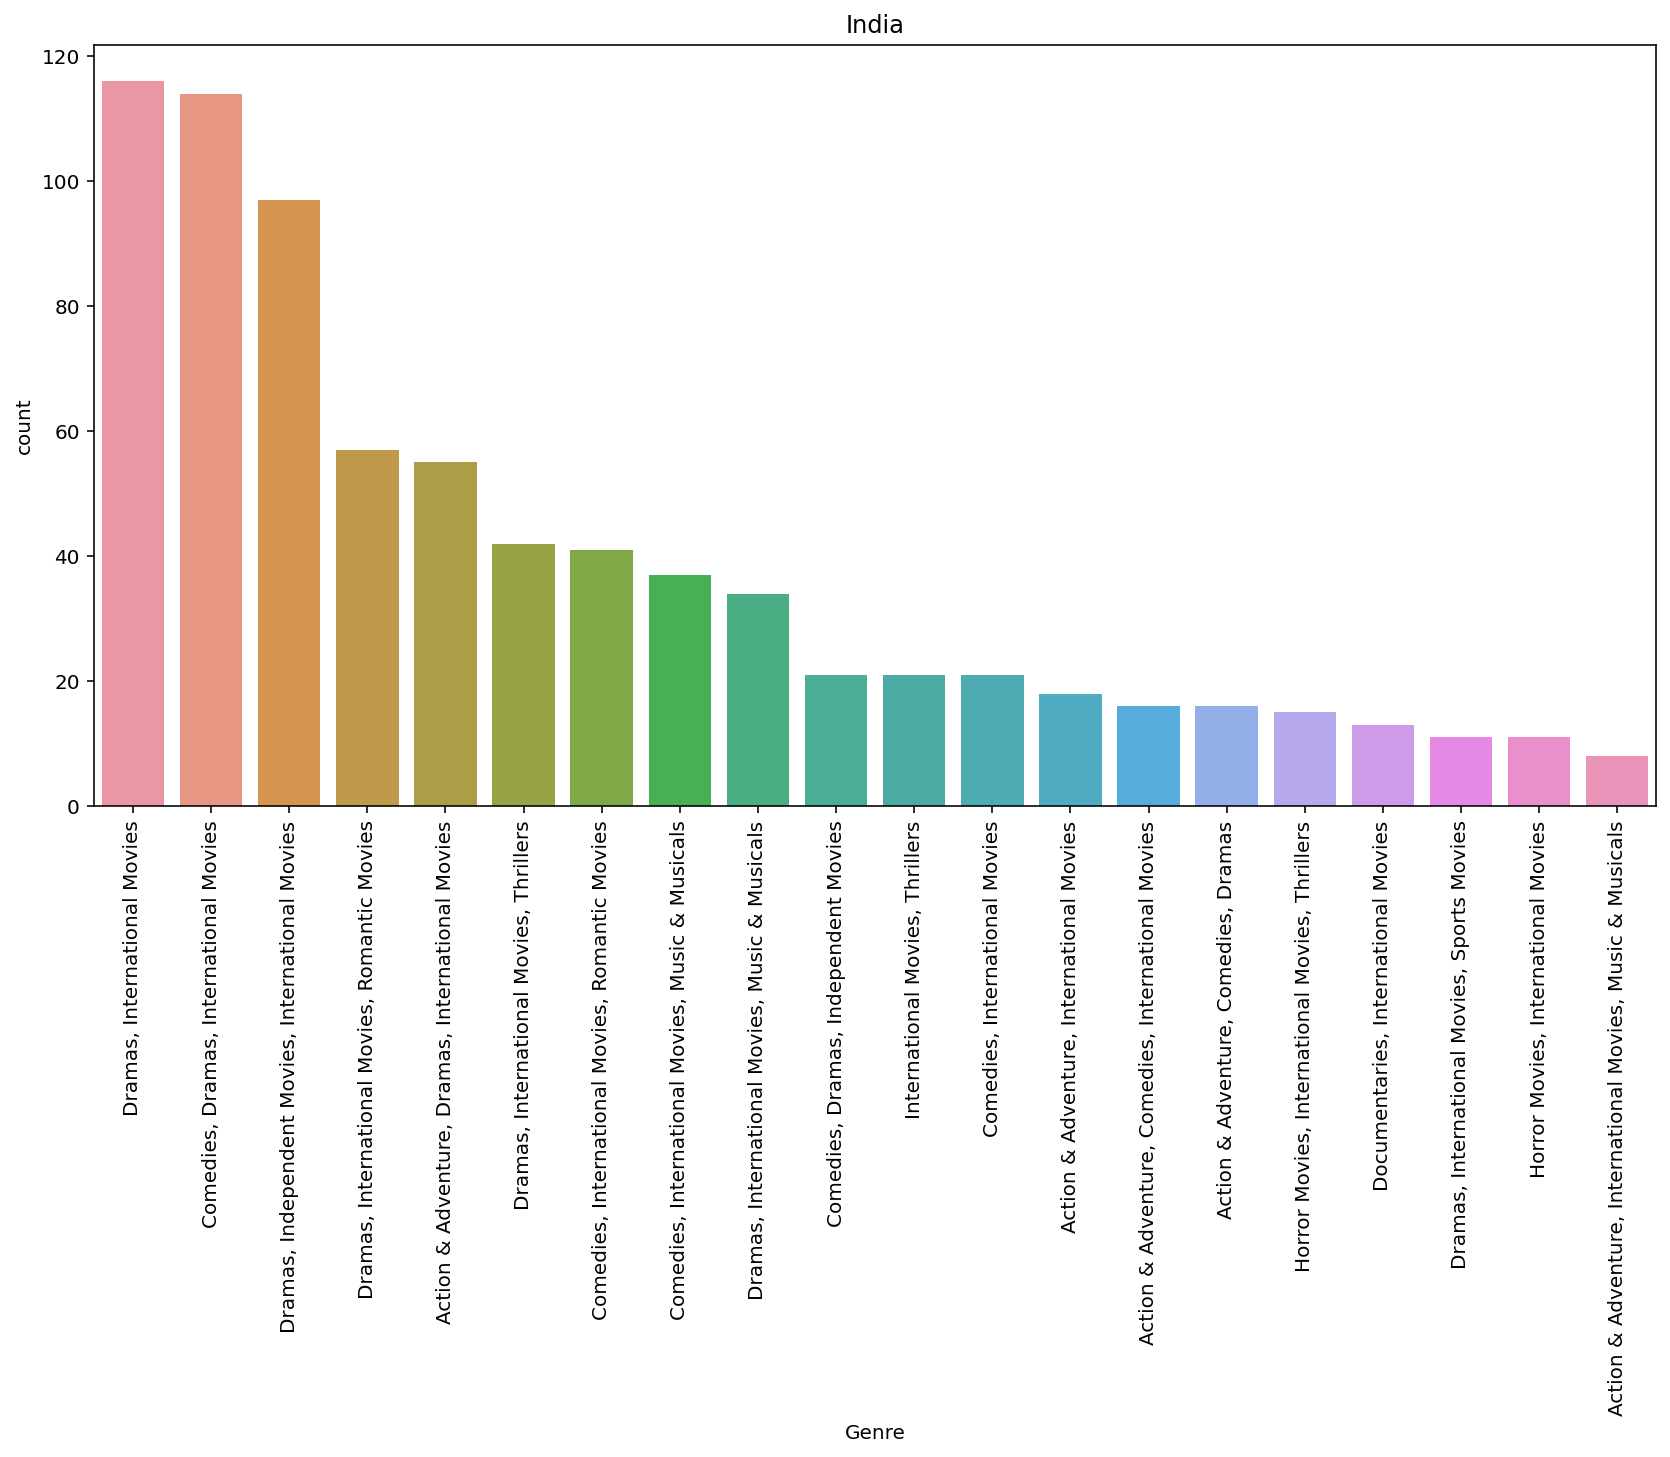

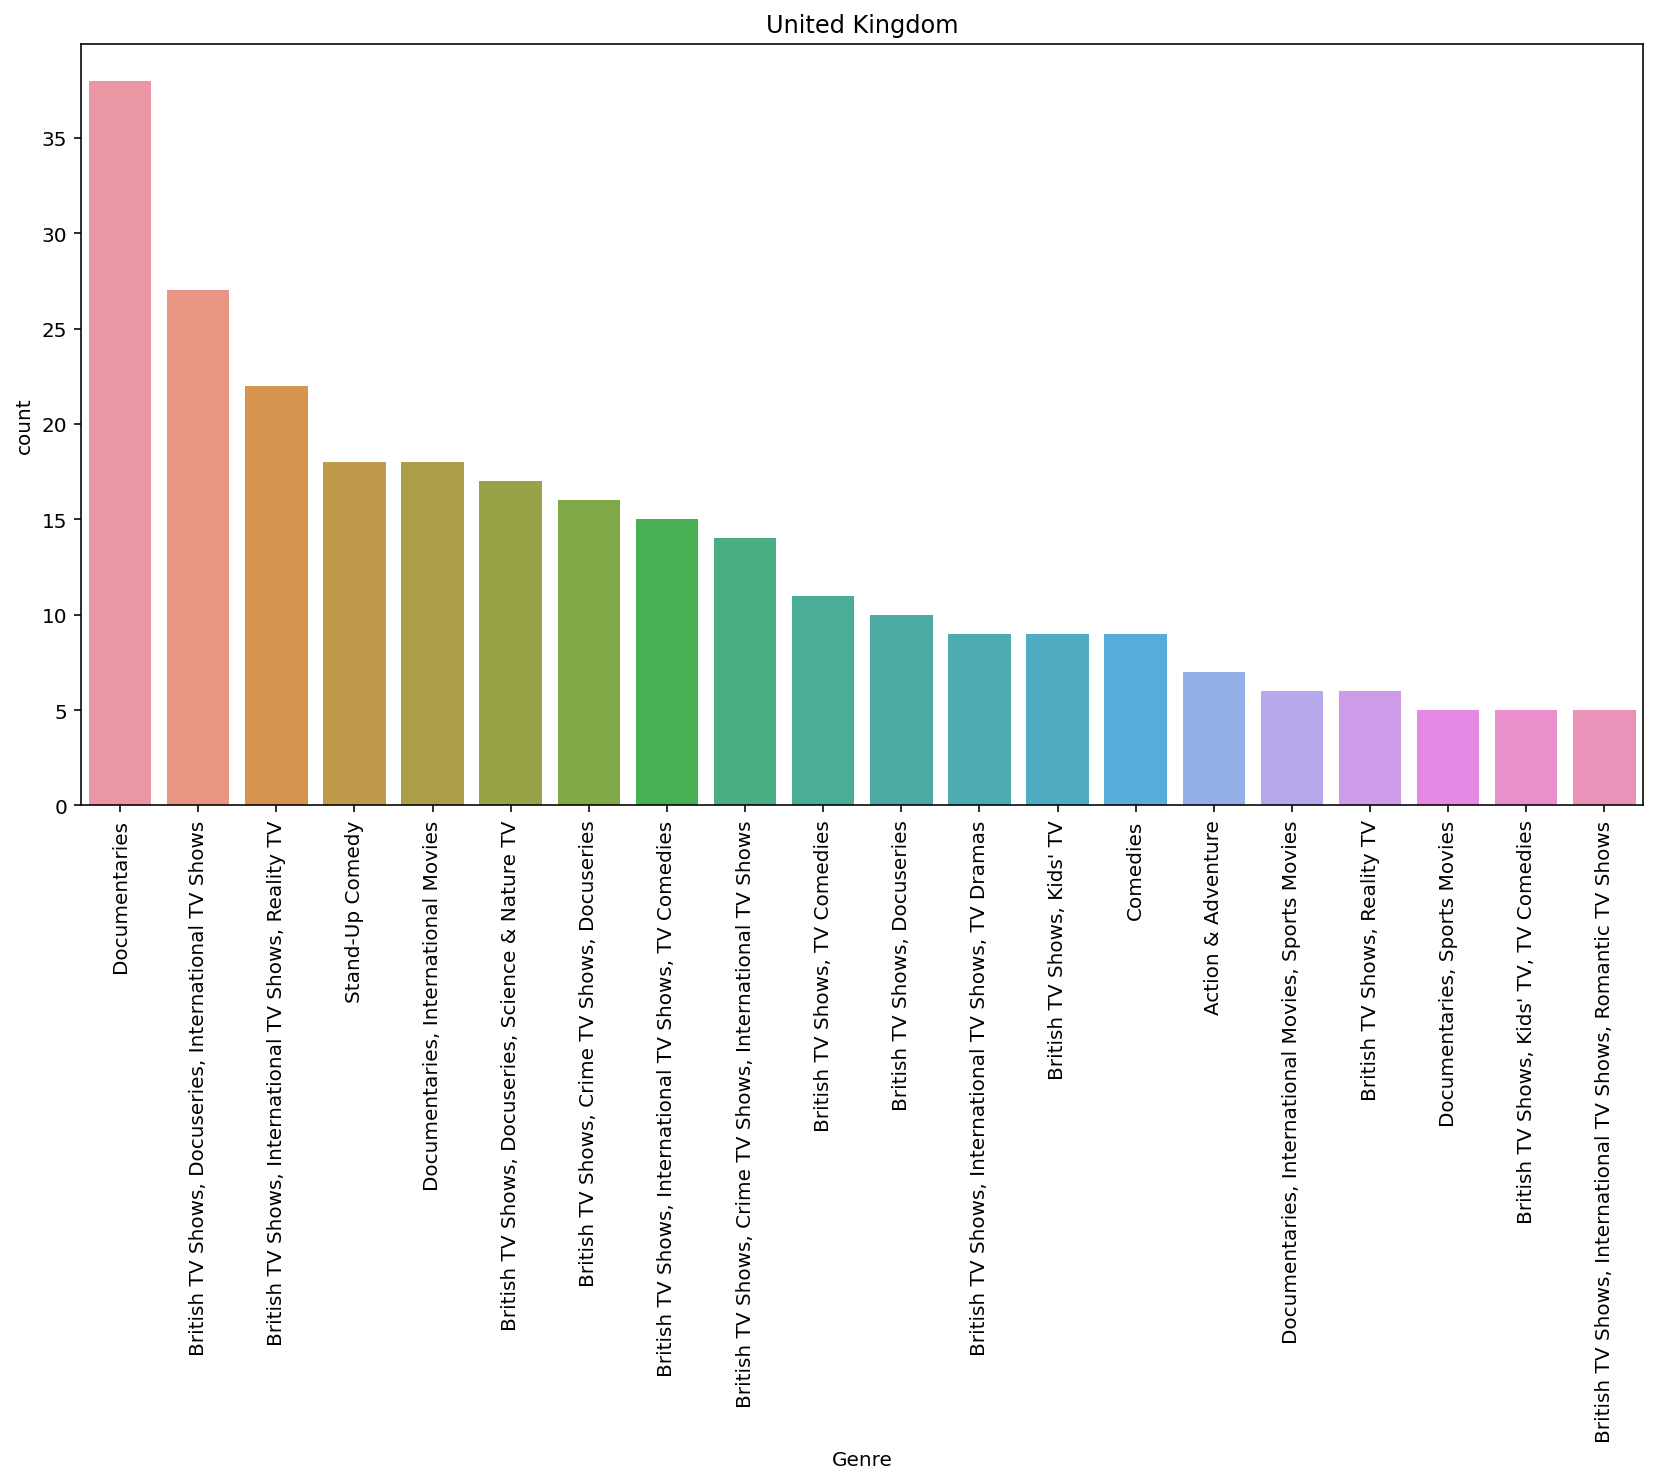

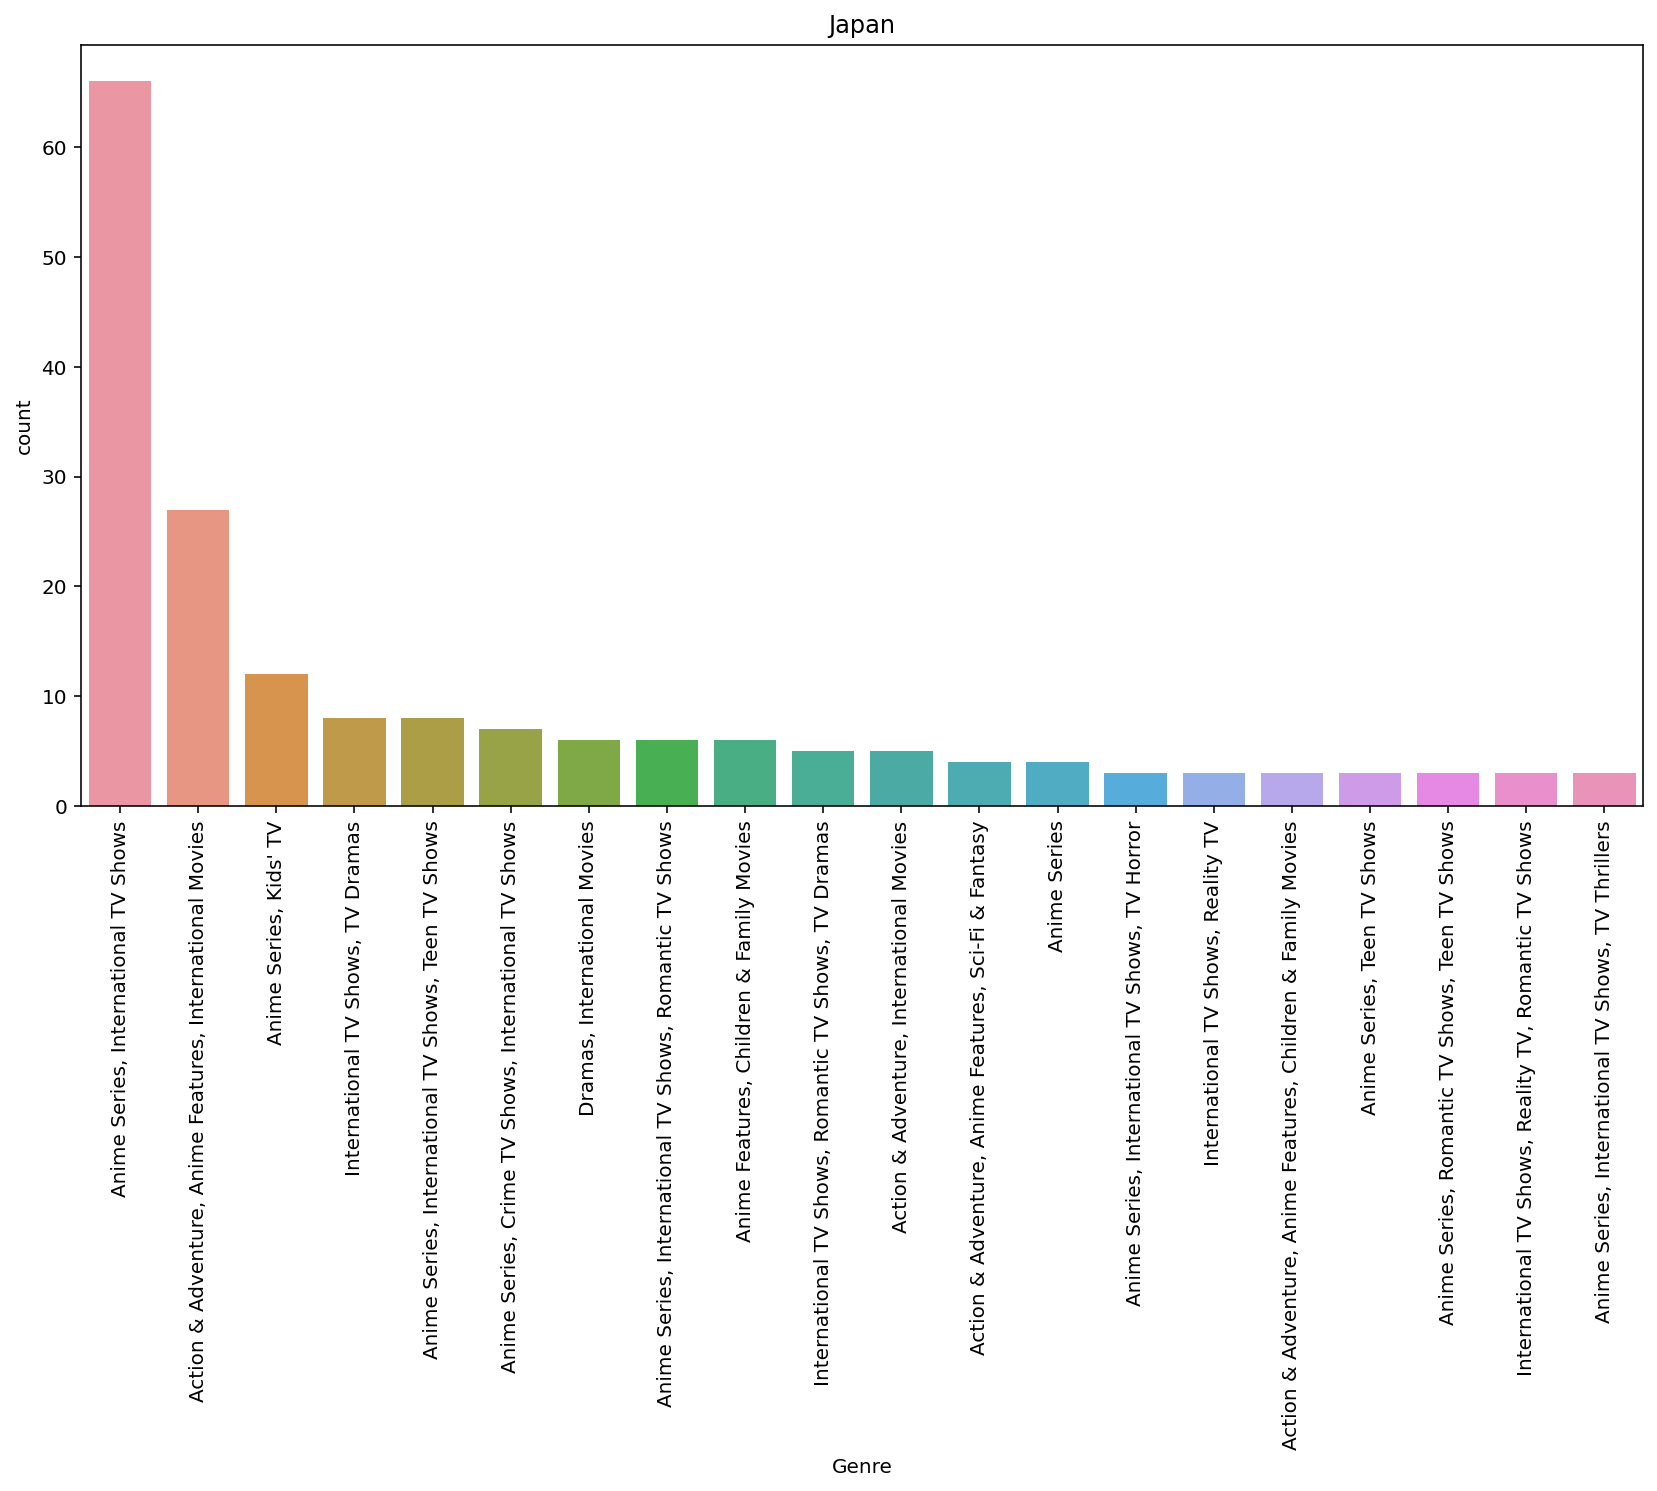

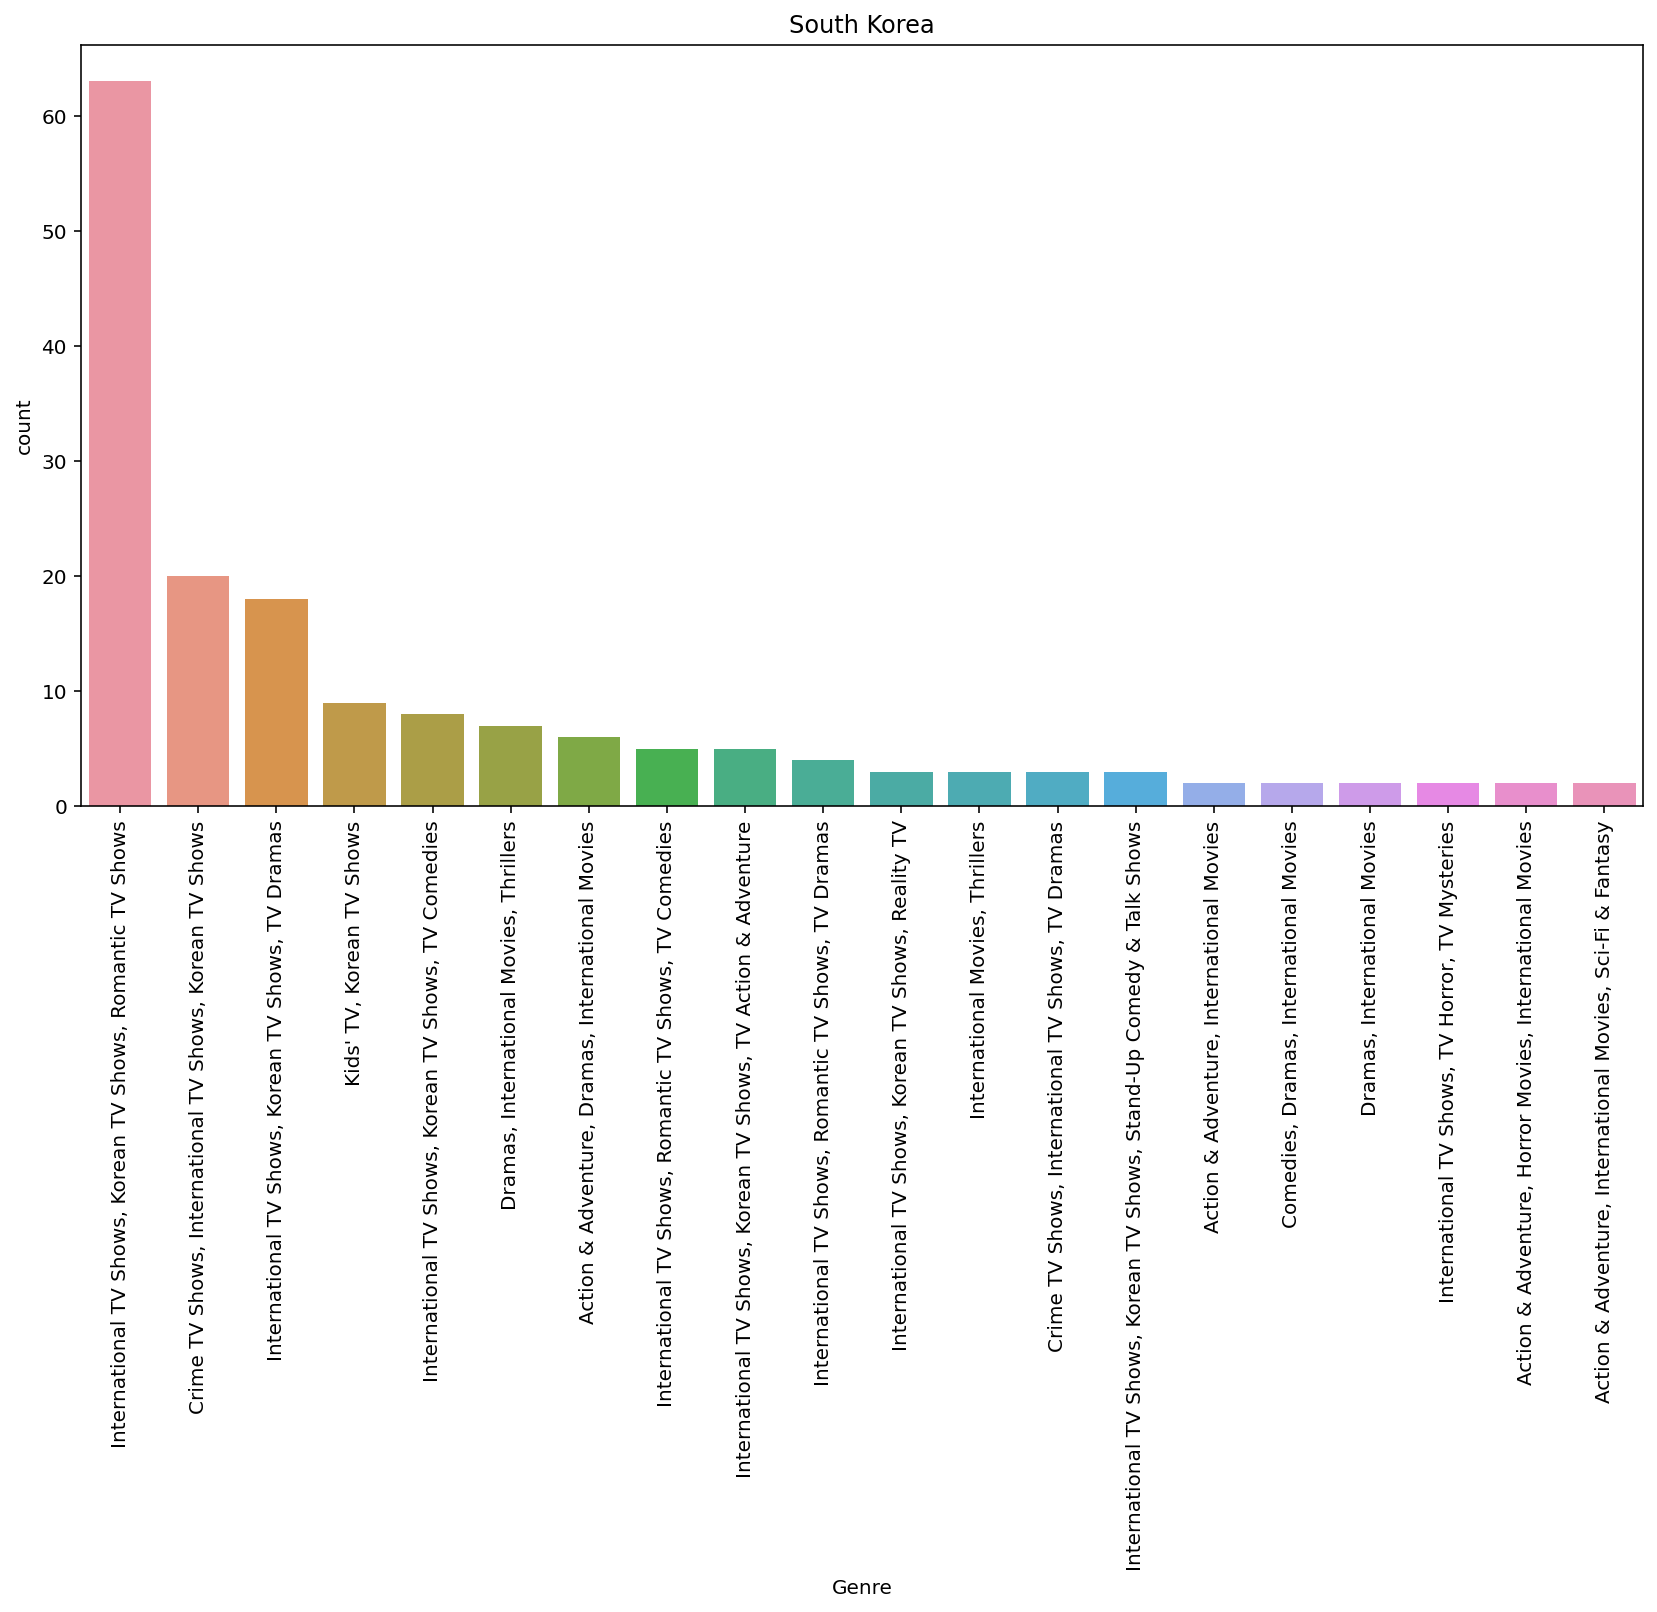

In [149]:
for country in top_10_country['country'][:5].values:
  genres_count = pd.DataFrame(get_genres_count(country))
  plt.figure()
  sns.barplot('listed_in', 'count' ,data= genres_count[:20])
  plt.title(country)
  plt.xlabel('Genre')
  plt.xticks(rotation = 90)
  plt.show

## <b>Understanding what type content is available in different countries

In [ ]:
type_of_content =  dataset[['country','type']].value_counts().reset_index().rename(columns={0: 'count'})
type_of_content.head(20)

,country,type,count
0,United States,Movie,1847
1,India,Movie,852
2,United States,TV Show,699
3,United Kingdom,TV Show,203
4,United Kingdom,Movie,193
5,Japan,TV Show,155
6,South Korea,TV Show,147
7,Canada,Movie,118
8,Spain,Movie,89
9,Egypt,Movie,89


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


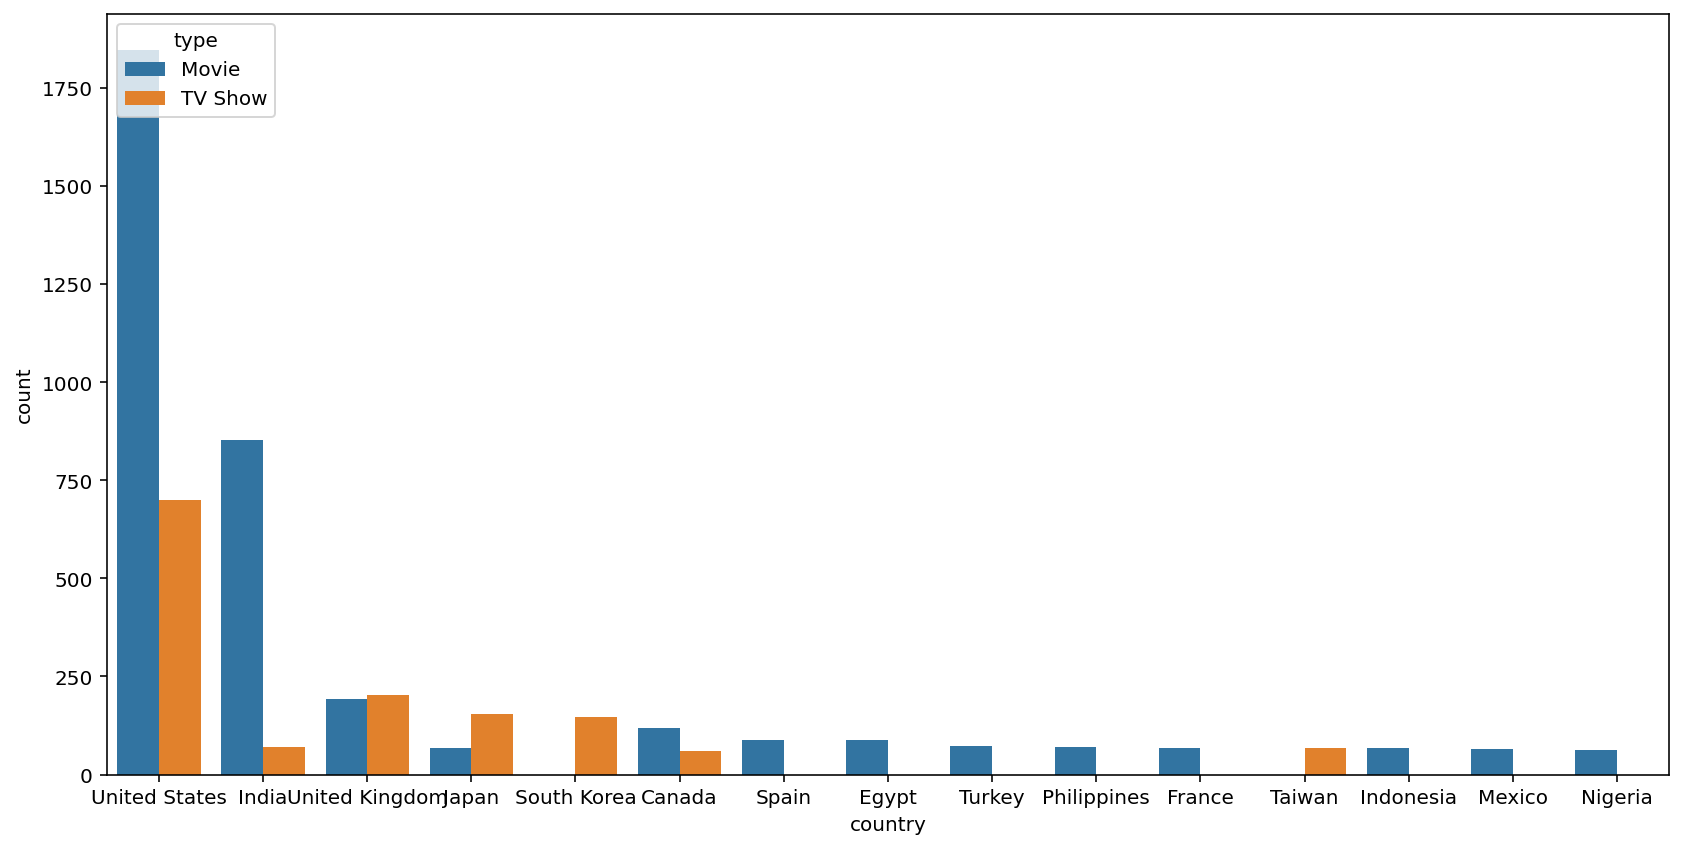

In [ ]:
# Visualize top 10 countries producing contents in netflix
sns.barplot('country', 'count',hue='type',data=type_of_content[:20])
rcParams['figure.figsize'] = 10, 5

In [111]:
type_of_content.tail(10)

,country,type,count
763,"Spain, United Kingdom",TV Show,1
764,"Spain, Italy",Movie,1
765,"Spain, United Kingdom",Movie,1
766,"Spain, Thailand, United States",Movie,1
767,"Spain, Switzerland",Movie,1
768,"Spain, Portugal",Movie,1
769,"Spain, Mexico, France",Movie,1
770,"Spain, Italy, Argentina",Movie,1
771,"Spain, Italy",TV Show,1
772,"Norway, Germany, Sweden",TV Show,1


## <b>Is Netflix has increasingly focusing on TV rather than movies in recent years.



In [87]:
type_year_count = dataset[['type', 'release_year']].value_counts().reset_index().rename(columns={0: 'count'})
type_year_count.head(10)

,type,release_year,count
0,Movie,2017,716
1,Movie,2018,688
2,Movie,2016,623
3,Movie,2019,531
4,TV Show,2020,417
5,Movie,2020,388
6,TV Show,2019,368
7,Movie,2015,363
8,TV Show,2018,332
9,TV Show,2017,241


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


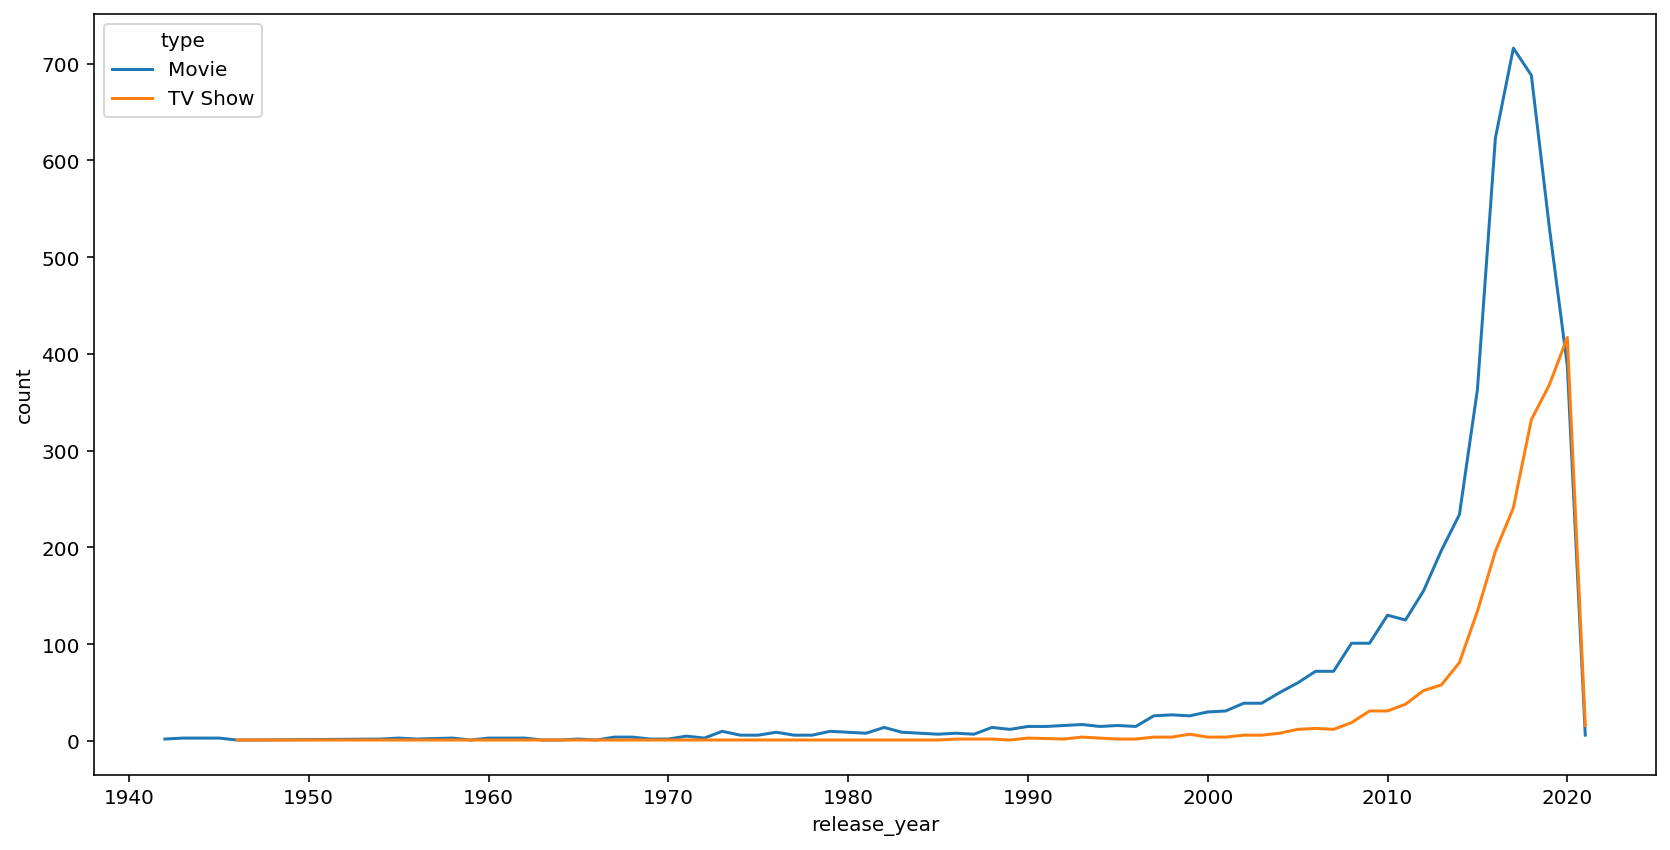

In [112]:
sns.lineplot('release_year', 'count', hue='type', data=type_year_count)
rcParams['figure.figsize'] = 15,5

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


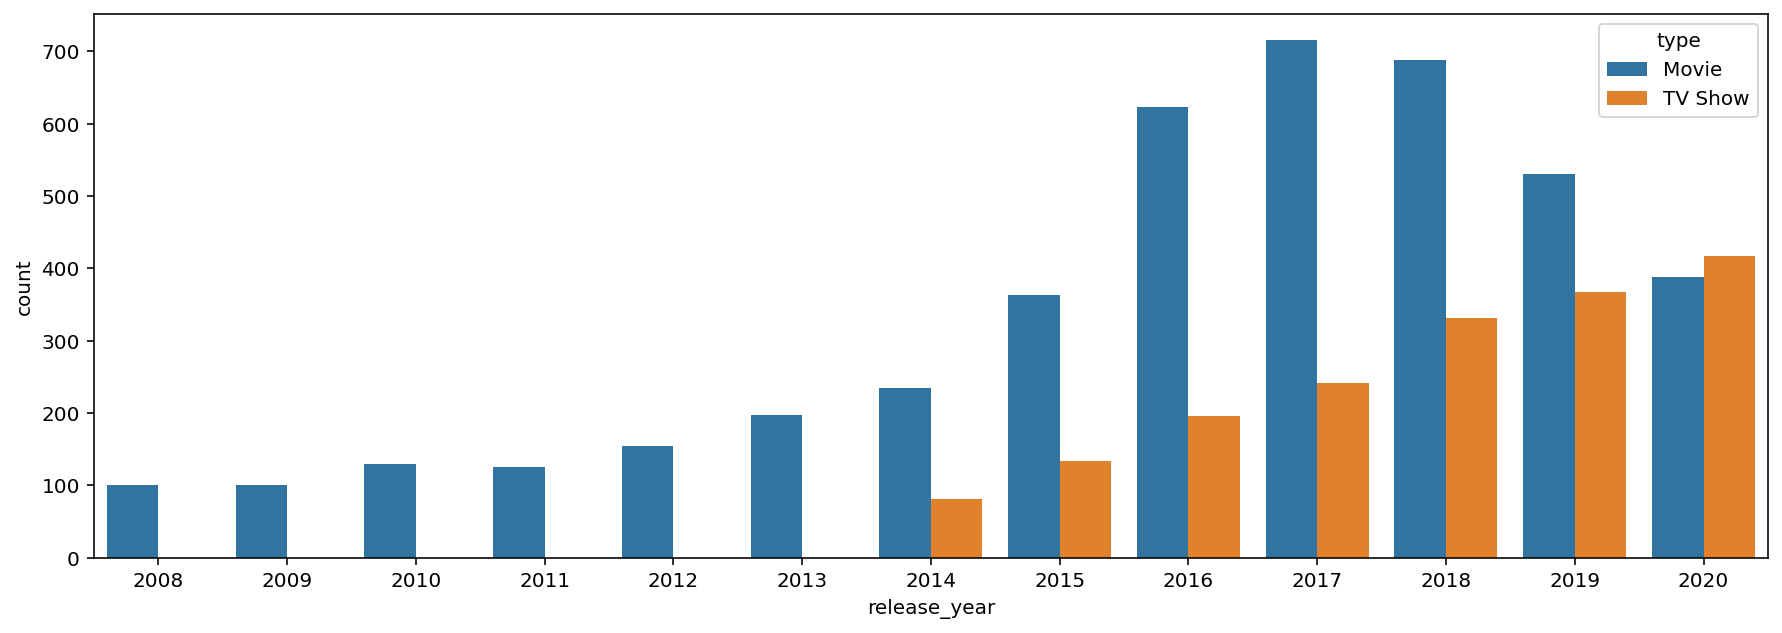

In [113]:
sns.barplot('release_year', 'count', hue='type', data=type_year_count[:20])
rcParams['figure.figsize'] = 14,7

# <b> Clustering similar content by matching text-based features

In [90]:
dataset.head()

,type,title,country,date_added,release_year,rating,duration,listed_in,description
0,TV Show,3%,Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,Movie,7:19,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,Movie,23:59,Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,Movie,9,United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,Movie,21,United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


## <b> Preprocessing

### **Removing punctuations**

In [91]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

### **Apply the function to each examples**

In [92]:
dataset['description'] = dataset['description'].apply(remove_punctuation)
dataset['description'].head()

0    In a future where the elite inhabit an island ...
1    After a devastating earthquake hits Mexico Cit...
2    When an army recruit is found dead his fellow ...
3    In a postapocalyptic world ragdoll robots hide...
4    A brilliant group of students become cardcount...
Name: description, dtype: object

### **Removing stopwords**

**Extract the stop words**

In [93]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [94]:
# extracting the stopwords from nltk library
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [95]:
print("Number of stopwords: ", len(sw))

Number of stopwords:  179


### **Function to remove stopwords**

In [96]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [97]:
dataset['description'] = dataset['description'].apply(stopwords)
dataset['description'].head()

0    future elite inhabit island paradise far crowd...
1    devastating earthquake hits mexico city trappe...
2    army recruit found dead fellow soldiers forced...
3    postapocalyptic world ragdoll robots hide fear...
4    brilliant group students become cardcounting e...
Name: description, dtype: object

### **Top words before stemming**

### **Collect vocabulary count**

In [98]:
# create a count vectorizer object
count_vectorizer = CountVectorizer()
# fit the count vectorizer using the text data
count_vectorizer.fit(dataset['description'])
# collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items()

#### Store the vocab and counts in a pandas dataframe

In [99]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_bef_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

#### **Bar plot of top words before stemming**

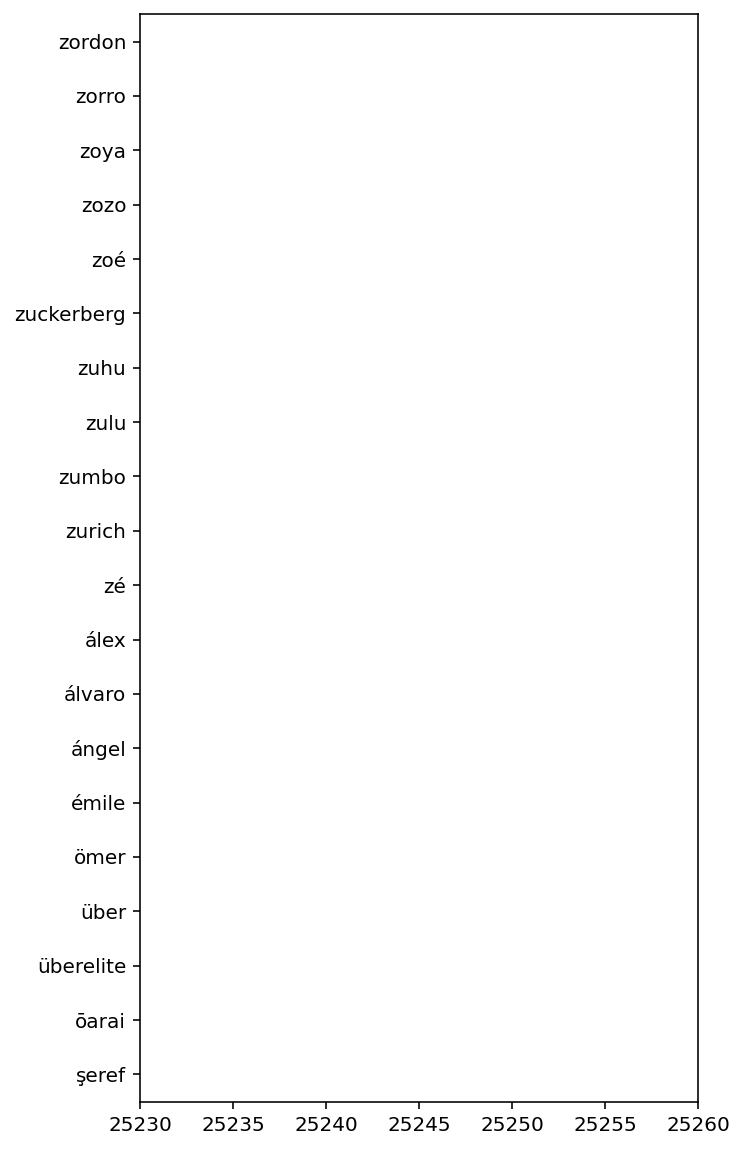

In [100]:
top_vacab = vocab_bef_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (25230, 25260))

###  **Stemming operations**

### Stemming operation bundles together words of same root. e.g. stem operation bundles "response" and "respond" into a common "respon" 

**A funtion to carry out stemming operation**

In [101]:
# create an object of stemming function
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

**Apply the function to each examples**

In [102]:
dataset['description'] = dataset['description'].apply(stemming)
dataset['description'].head()

0    futur elit inhabit island paradis far crowd sl...
1    devast earthquak hit mexico citi trap survivor...
2    armi recruit found dead fellow soldier forc co...
3    postapocalypt world ragdol robot hide fear dan...
4    brilliant group student becom cardcount expert...
Name: description, dtype: object

### **Top words after stemming operation**

**Collect vocabulary count**

In [103]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer("english")

# fit the vectorizer using the text data
tfid_vectorizer.fit(dataset['description'])

# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

**Bar plot of top words after stemming**

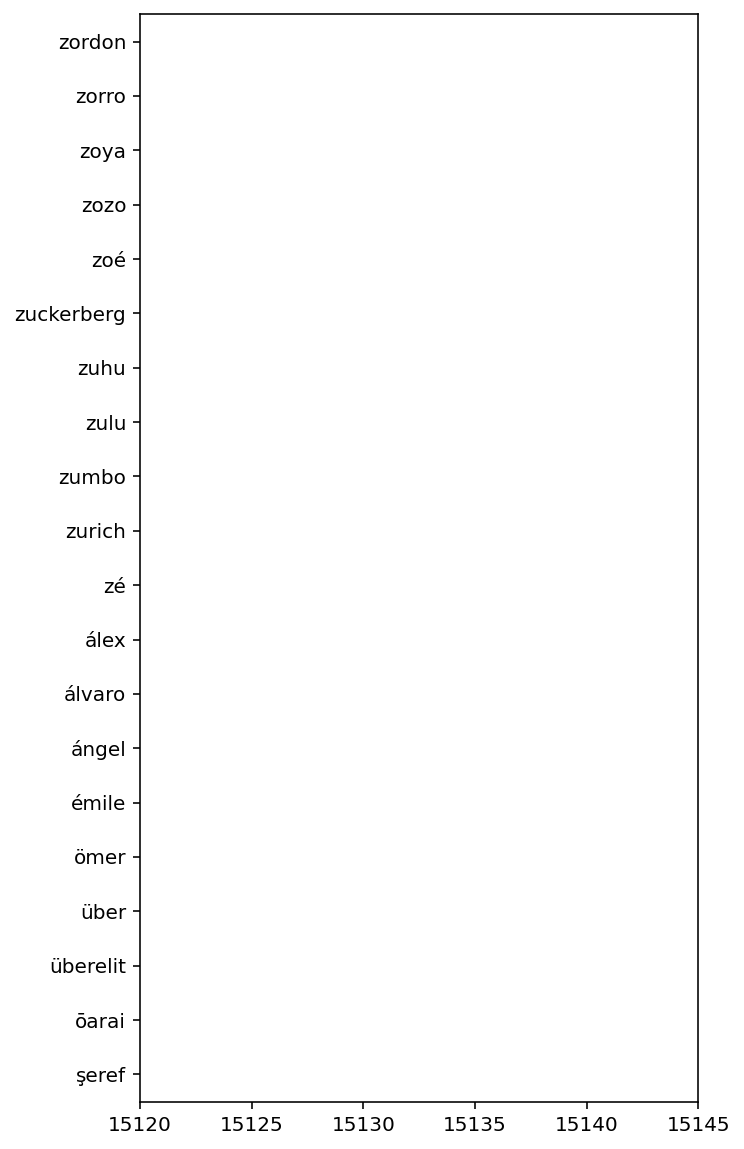

In [104]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_after_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_after_stem = vocab_after_stem.sort_values(ascending=False)
# plot of the top vocab
top_vacab = vocab_after_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (15120, 15145))